# Pooling and Blending

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/jckantor/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()
helper.install_ipopt()

pyomo was previously installed
cbc was previously installed
ipopt was previously installed


True

## P and Q parameterizations of Pooling Problems

The model presented above introduced a decision variable $f$ corresponding to the milk fat composition of the pool. In more general problems with $P$ pools and $K$ material composition variables will be $P \times K$ values for $f_{p,k}$. Intuitively, the determination of $f$ decomposes the pooling problem into two interacting parts ... the formulation of an blending pool from the remote farms with composition $f$, and the blending of deliveries to the customers using a combination of the pool and supplies purchased from local farms. In the literature this is called the P- 

An alternative formulation is to introduce a different set of decision variables, here called $w_r \geq 0$, that described the fraction of the pool that is obtained from remote farm $r\in R$. The relationships between variables $z_r$ and $y_c$ are then given by

$$
\begin{align*}
z_r & = w_r \sum_{c\in C} y_c & \forall r \in R
\end{align*}
$$

Working with the objective function

$$
\begin{align*}
\text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c}
    + \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r z_{r} \\
& = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c} 
    + \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r w_r \sum_{c\in C}y_c \\
\end{align*}
$$

which introduces bilinear terms into the objective function.

$$
\begin{align*}
\implies \text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_l - \text{cost}_c) x_{l,c} 
    + \sum_{c\in C} \left(\text{price}_c - \sum_{r\in R} \text{cost}_r w_r \right)y_{c}
\end{align*}
$$

As before, the product delivered to each customer can not exceed demand.

$$
\begin{align*}
\sum_{l\in L} x_{l, c} + y_{c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

A incoming and outgoing flows to the pool must balance.

$$
\begin{align*}
\sum_{r\in R}w_{r} & =  1 \\
\end{align*}
$$

The average milk fat composition of the pool, $f$, must satisfy an overall balance on milk fat entering the pool from the remote farms and the milk fat delivered to customers. Finally, the minimum milk fat required by each customer $c\in C$ satisfies a blending constraint.

$$
\begin{align*}
\sum_{l\in L} \left(\text{conc}_c - \text{conc}_l\right) x_{l,c} +
\left(\sum_{r\in R} \text{conc}_r w_r - \text{conc}_c\right) y_c & \geq 0 & \forall c\in C
\end{align*}
$$

In this formulation bilinear terms appear in the objective function and composition constraints. The following cells plot the value of the objective for fixed values of $w_{\text{Farm C}}$ where $w_{\text{Farm D}} = 1 - w_{\text{Farm C}}$.

In [3]:
import pyomo.environ as pyo
import numpy as np

def q_milk(w=0, q="fat"):
    
    m = pyo.ConcreteModel('Milk Pooling Model q-parameterization')

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, domain=pyo.NonNegativeReals)
    m.z = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    
    m.w = pyo.Param(m.R, mutable=True)
    m.w["Farm C"] = w
    m.w["Farm D"] = 1 - w

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum( m.y[c]*(customers.loc[c, "price"] - sum(m.w[r] * suppliers.loc[r, "cost"] for r in m.R)) for c in m.C)

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return sum((suppliers.loc[l, q] - customers.loc[c, q]) * m.x[l, c] for l in m.L) \
                 + (sum(suppliers.loc[r, q] * m.w[r] for r in m.R) - customers.loc[c, q]) * m.y[c] >= 0

    pyo.SolverFactory('cbc').solve(m)
    
    return m

w = np.linspace(0.0, 1.0, 200)
p = [q_milk(w).profit() for w in w]

NameError: name 'local_suppliers' is not defined

In [ ]:
import pyomo.environ as pyo

def p_milk_opt(q="fat"):
    
    m = pyo.ConcreteModel('Milk Pooling Model p-parameterization')

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, domain=pyo.NonNegativeReals)
    m.z = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    m.f = pyo.Var(bounds=(0, 1))

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum(m.y[c]*customers.loc[c, "price"] for c in m.C) \
               - sum(m.z[r]*suppliers.loc[r, "cost"] for r in m.R)

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint()
    def pool_balance(m,):
        return sum(m.z[r] for r in m.R) == sum(m.y[c] for c in m.C)
    
    @m.Constraint()
    def pool_quality(m):
        return sum(suppliers.loc[r, q] * m.z[r] for r in m.R) == m.f * sum(m.z[r] for r in m.R)
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return m.f * m.y[c] + sum(suppliers.loc[l, q] * m.x[l, c] for l in m.L) \
                 >= customers.loc[c, q] * (sum(m.x[l, c] for l in m.L) + m.y[c])

    pyo.SolverFactory('ipopt').solve(m)
    
    return m

m = p_milk_opt()
print(m.profit())
m.x.display()
m.y.display()
m.z.display()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(f, p)
ax.set_title("Milk Pooling - Q Parameterization")
ax.set_xlabel("Pool fraction w of Farm C")
ax.set_ylabel("Profit")
ax.grid(True)

As for the case of the P-parameterization, the bilinear Q-parameterization exhibits local maxima and saddle points. Nevertheless, the received wisdom is that the Q-parameterization yields higher performance and less likely to report a local maxima as solution.

In [183]:
import pyomo.environ as pyo

def q_milk_opt(q="fat"):
    
    m = pyo.ConcreteModel('Milk Pooling Model q-parameterization')

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, domain=pyo.NonNegativeReals)
    
    # proportion of pool from source r
    m.w = pyo.Var(m.R, bounds=(0, 1))

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum(m.y[c]*(customers.loc[c, "price"]) for c in m.C) \
               - sum(sum(m.y[c] * m.w[r] * suppliers.loc[r, "cost"] for r in m.R) for c in m.C)
    
    @m.Constraint()
    def pool_balance(m):
        return sum(m.w[r] for r in m.R) == 1

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return sum((suppliers.loc[l, q] - customers.loc[c, q]) * m.x[l, c] for l in m.L) \
                 + sum(suppliers.loc[r, q] * m.w[r] * m.y[c] for r in m.R)  \
                 - customers.loc[c, q] * m.y[c] >= 0

    pyo.SolverFactory('ipopt').solve(m)
    
    return m

m = q_milk_opt()
print(m.profit())
m.w.display()
m.x.display()
m.y.display()

71500.00069370153
w : Size=2, Index=R
    Key    : Lower : Value : Upper : Fixed : Stale : Domain
    Farm C :     0 :   1.0 :     1 : False : False :  Reals
    Farm D :     0 :   0.0 :     1 : False : False :  Reals
x : Size=4, Index=x_index
    Key                      : Lower : Value             : Upper : Fixed : Stale : Domain
    ('Farm A', 'Customer A') :     0 : 5750.000060205816 :  None : False : False : NonNegativeReals
    ('Farm A', 'Customer B') :     0 :               0.0 :  None : False : False : NonNegativeReals
    ('Farm B', 'Customer A') :     0 :               0.0 :  None : False : False : NonNegativeReals
    ('Farm B', 'Customer B') :     0 :               0.0 :  None : False : False : NonNegativeReals
y : Size=2, Index=C
    Key        : Lower : Value              : Upper : Fixed : Stale : Domain
    Customer A :     0 : 249.99999980348457 :  None : False : False : NonNegativeReals
    Customer B :     0 :  2500.000025018958 :  None : False : False : NonNegativeR

In [160]:
import pyomo.environ as pyo

m = pyo.ConcreteModel('q-parameterization')

# define sources 
m.L = pyo.Set(initialize=local_suppliers.index)
m.R = pyo.Set(initialize=remote_suppliers.index)

# define customers
m.C = pyo.Set(initialize=customers.index)

# define flowrates
m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
m.y = pyo.Var(m.C, bounds = lambda m, c: (0, customers.loc[c, "demand"]))

# proportion of pool from source r
m.w = pyo.Var(m.R, bounds=(0, 1))

# relaxation
m.v = pyo.Var(m.R, m.C, domain=pyo.NonNegativeReals)

# m.w * m.y
@m.Block(m.R, m.C)
def mccormick(b, r, c):
    m = b.model()
    b.lb1 = pyo.Constraint(expr=m.v[r, c] >= \
                m.y[c].lower * m.w[r] + m.w[r].lower * m.y[c] - m.w[r].lower * m.y[c].lower)
    b.lb2 = pyo.Constraint(expr=m.v[r, c] >= \
                m.y[c].upper * m.w[r] + m.w[r].upper * m.y[c] - m.w[r].upper * m.y[c].upper)
    b.ub1 = pyo.Constraint(expr=m.v[r, c] >= \
                m.y[c].upper * m.w[r] + m.w[r].lower * m.y[c] - m.w[r].lower * m.y[c].upper)
    b.ub2 = pyo.Constraint(expr=m.v[r, c] >= \
                m.y[c].lower * m.w[r] + m.w[r].upper * m.y[c] - m.w[r].upper * m.y[c].lower)                 

@m.Objective(sense=pyo.maximize)
def objectivt(m):
    return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
           + sum(m.y[c]*(customers.loc[c, "price"]) for c in m.C) \
           - sum(sum(m.v[r, c] * suppliers.loc[r, "cost"] for r in m.R) for c in m.C)

@m.Expression()
def profit(m):
    return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
           + sum(m.y[c]*(customers.loc[c, "price"]) for c in m.C) \
           - sum(sum(m.y[c] * m.w[r] * suppliers.loc[r, "cost"] for r in m.R) for c in m.C)
    
@m.Constraint()
def pool_balance(m):
    return sum(m.w[r] for r in m.R) == 1

@m.Constraint(m.C)
def customer_demand(m, c):
    return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]

@m.Constraint(m.C)
def customer_quality(m, c):
    return sum((suppliers.loc[l, q] - customers.loc[c, q]) * m.x[l, c] for l in m.L) \
                + sum(suppliers.loc[r, q] * m.v[r, c] for r in m.R)  \
                - customers.loc[c, q] * m.y[c] >= 0

pyo.SolverFactory('cbc').solve(m)

print("Profit = ", m.profit())
#m.w.display()
m.x.display()
m.y.display()

m.v.display()

for c in m.C:
    print(f"{c}  {m.y[c].lower} {m.y[c].upper:8.2f} {m.y[c]():8.2f}")
    
for r in m.R:
    print(f"{r}  {m.w[r].lower} {m.w[r].upper:8.2f} {m.w[r]():8.2f}")

Profit =  79250.0
x : Size=4, Index=x_index
    Key                      : Lower : Value  : Upper : Fixed : Stale : Domain
    ('Farm A', 'Customer A') :     0 :    0.0 :  None : False : False : NonNegativeReals
    ('Farm A', 'Customer B') :     0 :    0.0 :  None : False : False : NonNegativeReals
    ('Farm B', 'Customer A') :     0 : 3000.0 :  None : False : False : NonNegativeReals
    ('Farm B', 'Customer B') :     0 : 1250.0 :  None : False : False : NonNegativeReals
y : Size=2, Index=C
    Key        : Lower : Value  : Upper  : Fixed : Stale : Domain
    Customer A :     0 : 3000.0 : 6000.0 : False : False :  Reals
    Customer B :     0 : 1250.0 : 2500.0 : False : False :  Reals
v : Size=4, Index=v_index
    Key                      : Lower : Value  : Upper : Fixed : Stale : Domain
    ('Farm C', 'Customer A') :     0 : 3000.0 :  None : False : False : NonNegativeReals
    ('Farm C', 'Customer B') :     0 : 1250.0 :  None : False : False : NonNegativeReals
    ('Farm D', 'Cust

In [73]:
m.y["Customer A"].lower

0

## Reformulating the model (Ben-Tal, 1994)

The model presented above introduced a decision variable $f$ corresponding to the pool composition. Essentially the choice of $f$ decomposes the problem into two parts ... the formulation of an blending pool from the remote farms with composition $f$, and the blending of deliveries to the customers using a combination of the pool and additional supplies purchased from local farms. 

An alternative formulation is to introduce a different set of decision variables, here called $w_r \geq 0$, that described the fraction of the pool that is obtained from remote farm $r\in R$. The relationships between variables $z_r$ and $y_c$ are then given by

$$
\begin{align*}
z_r & = w_r \sum_{c\in C} y_c & \forall r \in R
\end{align*}
$$

The overall balance of inputs and outputs on the pool is given by

$$
\begin{align*}
\sum_{r\in R} w_r & = 1
\end{align*}
$$

Working with the objective function

$$
\begin{align*}
\text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c}
    + \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r z_{r} \\
& = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c} 
    + \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r w_r \sum_{c\in C}y_c \\
\end{align*}
$$

which introduces bilinear terms into the objective function.

$$
\begin{align*}
\implies \text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_l - \text{cost}_c) x_{l,c} 
    + \sum_{c\in C} \left(\text{price}_c - \sum_{r\in R} \text{cost}_r w_r \right)y_{c}
\end{align*}
$$

As before, the product delivered to each customer can not exceed demand.

$$
\begin{align*}
\sum_{l\in L} x_{l, c} + y_{c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

A incoming and outgoing flows to the pool must balance.

$$
\begin{align*}
\sum_{r\in R}w_{r} & =  1 \\
\end{align*}
$$

The average milk fat composition of the pool, $f$, must satisfy an overall balance on milk fat entering the pool from the remote farms and the milk fat delivered to customers. Finally, the minimum milk fat required by each customer $c\in C$ satisfies a blending constraint.

$$
\begin{align*}
\sum_{l\in L} \left(\text{conc}_c - \text{conc}_l\right) x_{l,c} +
\left(\sum_{r\in R} \text{conc}_r w_r - \text{conc}_c\right) y_c & \geq 0 & \forall c\in C
\end{align*}
$$

In this formulation bilinear terms appear in the objective function and composition constraints. The following cells plot the value of the objective for fixed values of $w_{\text{Farm C}}$ where $w_{\text{Farm D}} = 1 - w_{\text{Farm C}}$

In [125]:
import pyomo.environ as pyo

def q_milk(w=0, q="fat"):
    
    m = pyo.ConcreteModel('Milk Pooling Model q-parameterization')

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define flowrates
    m.x = pyo.Var(m.L * m.C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.C, domain=pyo.NonNegativeReals)
    m.z = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    
    m.w = pyo.Param(m.R, mutable=True)
    m.w["Farm C"] = w
    m.w["Farm D"] = 1 - w

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum( m.y[c]*(customers.loc[c, "price"] - sum(m.w[r] * suppliers.loc[r, "cost"] for r in m.R)) for c in m.C)

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]
    
    @m.Constraint(m.C)
    def customer_quality(m, c):
        return sum((suppliers.loc[l, q] - customers.loc[c, q]) * m.x[l, c] for l in m.L) \
                 + (sum(suppliers.loc[r, q] * m.w[r] for r in m.R) - customers.loc[c, q]) * m.y[c] >= 0

    pyo.SolverFactory('cbc').solve(m)
    
    return m

w = np.linspace(0.0, 1.0, 200)
p = [q_milk(w).profit() for w in w]

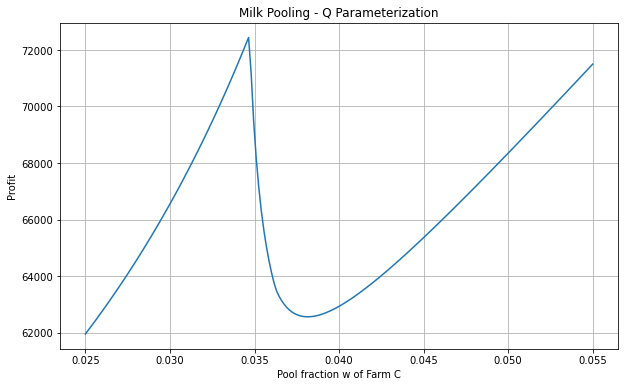

In [126]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(f, p)
ax.set_title("Milk Pooling - Q Parameterization")
ax.set_xlabel("Pool fraction w of Farm C")
ax.set_ylabel("Profit")
ax.grid(True)

## WORK PAST HERE IS WILL BE USED FOR OTHER NOTEBOOKS


## Q-Parameterization

There are multiple formulations of the pooling problem. The following model uses the q-parameterization where a set of decision variables $q_{r, p}$ denote the fraction of pool $p$ that flow from source $r$. Let $z_{r p}$ be the actual flow from $r$ to $p$, then

$$
\begin{align*}
z_{r, p} & = f_{r, p} \sum_{c\in C} y_{p, c} & \forall r \in R
\end{align*}
$$

The objective is to maximize profit

$$
\begin{align*}
\text{Profit} & = \sum_{l,c} (\text{price}_c - \text{cost}_l) x_{l,c}
+ \sum_{p, c} \text{price}_c y_{p, c} - \sum_{r, p} \text{cost}_r z_{r, p}
\end{align*}
$$

where a sum over a pair of indices $i, j$ means summing over all available links between source $i$ and destination $j$. 

The product quality constraints also include bilinear terms. 

$$
\begin{align*}
\sum_{l,c} x_{l,c} \text{conc}_{l, k} + \sum_p y_{p,c} \sum_{r}f_{r, p} \text{conc}_{r,k} & 
\geq \text{conc}_{c, k}(\sum_{l,c} x_{l,c} + \sum_{p,c} y_{p,c}) & \forall k, c \in K \times C
\end{align*}
$$

Supply constraints

$$
\begin{align*}
\sum_{c\in C} x_{l, c} & \leq \text{supply}_l & \forall l\in L
\end{align*}
$$

$$
\begin{align*}
\sum_{p\in P} z_{r, p} & \leq \text{supply}_r & \forall r\in R
\end{align*}
$$

Customer demand constraints

$$
\begin{align*}
\sum_{l\in L} x_{l, c} + \sum_{p\in P} y_{p, c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

Pool capacity constraints

$$
\begin{align*}
\sum_{c} y_{p, c} & \leq \text{capacity}_p & \forall p \in P
\end{align*}
$$


## P-parameterization

The objective is to maximize profit

$$
\begin{align*}
\text{Profit} & = \sum_{l,c} (\text{price}_c - \text{cost}_l) x_{l,c}
+ \sum_{p, c} \text{price}_c y_{p, c} - \sum_{r, p} \text{cost}_r z_{r, p}
\end{align*}
$$


The raw materials from each of the local and remote suppliers can not exceed the supply.

$$
\begin{align*}
\sum_{c\in C} x_{l, c} & \leq \text{supply}_l & \forall l\in L
\end{align*}
$$

$$
\begin{align*}
\sum_{p\in P} z_{r, p} & \leq \text{supply}_r & \forall r\in R
\end{align*}
$$

The product delivered to each customer can not exceed demand.

$$
\begin{align*}
\sum_{l\in L} x_{l, c} + \sum_{p\in P} y_{p, c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

The incoming and outgoing flows must balance for each pool.

$$
\begin{align*}
\sum_{r\in R}z_{r, p} & = \sum_{c\in C} y_{p, c} & \forall p \in P\\
\end{align*}
$$

The incoming flow to each pool can not exceed the pool capacity.

$$
\begin{align*}
\sum_{r\in R} z_{r, p} & \leq \text{capacity}_p & \forall p\in P
\end{align*}
$$

Let $\gamma_{p,k}$ be the concentration of quality component $k$ in pool $p$. 

$$
\begin{align*}
\sum_{l} z_{l, p} \text{conc}_{l, k} & = \gamma_{p, k}\sum_{c} y_{p, c} & \forall p, k \in P \times K
\end{align*}
$$

Product quality requirements

$$
\begin{align*}
\sum_{p\in P} y_{p,c} \gamma_{p,k}  + \sum_{l,c} x_{l,c} \text{conc}_{l,k} 
& \geq \text{conc}_{c, k} (\sum_{l\in L} x_{l, c} + \sum_{p\in P} y_{p, c})
& \forall c, k \in C \times K
\end{align*}
$$


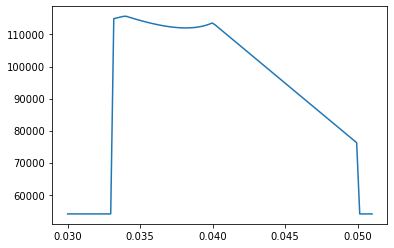

In [541]:
import pyomo.environ as pyo

def p_milk(f=0.):
    
    # f ranges from 0.033 to 0.05
    
    m = pyo.ConcreteModel()

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define pools
    m.P = pyo.Set(initialize=trucks.index)

    # define arcs
    m.L2C = m.L * m.C
    m.P2C = m.P * m.C
    m.R2P = m.R * m.P

    # set of quality components
    m.K = pyo.Set(initialize=["fat"])

    # define flowrates
    m.x = pyo.Var(m.L2C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.P2C, domain=pyo.NonNegativeReals)
    m.z = pyo.Var(m.R2P, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L2C) \
               + sum(m.y[p, c]*customers.loc[c, "price"] for p, c in m.P2C) \
               - sum(m.z[r, p]*suppliers.loc[r, "cost"] for r, p in m.R2P)

    @m.Constraint(m.L)
    def local_supply(m, l):
        return sum(m.x[l, c] for c in m.C) <= suppliers.loc[l, "capacity"]

    @m.Constraint(m.R)
    def remote_supply(m, r):
        return sum(m.z[r, p] for p in m.P) <= suppliers.loc[r, "capacity"]

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + sum(m.y[p, c] for p in m.P) <= customers.loc[c, "demand"]

    @m.Constraint(m.P)
    def pool_capacity(m, p):
        return sum(m.z[r, p] for r in m.R) <= trucks.loc[p, "capacity"]
    
    @m.Constraint(m.P)
    def pool_balance(m, p):
        return sum(m.z[r, p] for r in m.R) == sum(m.y[p, c] for c in m.C)
    
    @m.Constraint(m.P, m.K)
    def pool_quality(m, p, k):
        return sum(suppliers.loc[r, k] * m.z[r, p] for r in m.R) == f * sum(m.y[p, c] for c in m.C)
    
    @m.Constraint(m.C, m.K)
    def customer_quality(m, c, k):
        return f * sum(m.y[p, c] for p in m.P) \
               + sum(suppliers.loc[l, k] * m.x[l, c] for l in m.L) \
               >= customers.loc[c, k] * (sum(m.x[l, c] for l in m.L) + sum(m.y[p, c] for p in m.P))

    pyo.SolverFactory('mosek').solve(m)
    
    return m

f = np.linspace(0.03, 0.051, 100)
p = [p_milk(f).profit() for f in f]

plt.plot(f, p)

In [510]:
m = p_milk(.08)
m.x.display()
m.y.display()
m.z.display()

x : Size=4, Index=L2C
    Key                      : Lower : Value     : Upper : Fixed : Stale : Domain
    ('Farm A', 'Customer A') :     0 : 666.66667 :  None : False : False : NonNegativeReals
    ('Farm A', 'Customer B') :     0 :       0.0 :  None : False : False : NonNegativeReals
    ('Farm B', 'Customer A') :     0 : 333.33333 :  None : False : False : NonNegativeReals
    ('Farm B', 'Customer B') :     0 :    5000.0 :  None : False : False : NonNegativeReals
y : Size=2, Index=P2C
    Key                       : Lower : Value : Upper : Fixed : Stale : Domain
    ('Truck 1', 'Customer A') :     0 :   0.0 :  None : False : False : NonNegativeReals
    ('Truck 1', 'Customer B') :     0 :   0.0 :  None : False : False : NonNegativeReals
z : Size=2, Index=R2P
    Key                   : Lower : Value : Upper : Fixed : Stale : Domain
    ('Farm C', 'Truck 1') :     0 :   0.0 :  None : False : False : NonNegativeReals
    ('Farm D', 'Truck 1') :     0 :   0.0 :  None : False : False :

In [431]:
trucks = pd.DataFrame({
    "Truck 1": {"capacity": 800}}).T


import pyomo.environ as pyo

def milk_pool(f, g):

    f = pd.DataFrame({"Farm C": {"Truck 1": f, "Truck 1": g}, 
                       "Farm D": {"Truck 1": 1-f, "Truck 2": 1-g}
                     }).T

    m = pyo.ConcreteModel()

    # define sources 
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)

    # define customers
    m.C = pyo.Set(initialize=customers.index)

    # define pools
    m.P = pyo.Set(initialize=trucks.index)

    # define arcs
    m.L2C = m.L * m.C
    m.P2C = m.P * m.C
    m.R2P = m.R * m.P

    # set of quality components
    m.K = pyo.Set(initialize=["fat"])

    # define flowrates
    m.x = pyo.Var(m.L2C, domain=pyo.NonNegativeReals)
    m.y = pyo.Var(m.P2C, domain=pyo.NonNegativeReals)
    m.z = pyo.Var(m.R2P, domain=pyo.NonNegativeReals)

    @m.Constraint(m.R, m.P)
    def q_parameterization(m, r, p):
        return m.z[r, p] == f.loc[r, p] * sum(m.y[p, c] for c in m.C)

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return + sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L2C) \
               + sum(m.y[p, c]*customers.loc[c, "price"] for p, c in m.P2C) \
               - sum(m.z[r, p]*suppliers.loc[r, "cost"] for r, p in m.R2P)

    @m.Constraint(m.C, m.K)
    def quality(m, c, k):
        return sum(suppliers.loc[l, k] * m.x[l, c] for l in m.L)  >= customers.loc[c, k] * sum(m.x[l, c] for l in m.L)

    @m.Constraint(m.L)
    def local_supply(m, l):
        return sum(m.x[l, c] for c in m.C) <= suppliers.loc[l, "capacity"]

    @m.Constraint(m.R)
    def remote_supply(m, r):
        return sum(m.z[r, p] for p in m.P) <= suppliers.loc[r, "capacity"]

    @m.Constraint(m.C)
    def customer_demand(m, c):
        return sum(m.x[l, c] for l in m.L) + sum(m.y[p, c] for p in m.P) <= customers.loc[c, "demand"]

    @m.Constraint(m.P)
    def pool_capacity(m, p):
        return sum(m.z[r, p] for r in m.R) <= trucks.loc[p, "capacity"]

    pyo.SolverFactory('cbc').solve(m)
    
    return m

m = milk_pool(0, 0)

m.profit()

32400.0

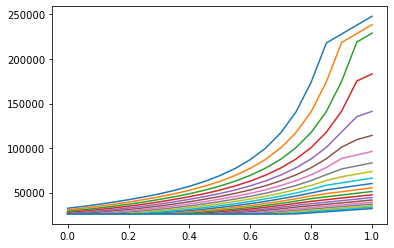

In [433]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for g in np.linspace(0, 1, 21):
    f = np.linspace(0, 1, 21)
    p = [milk_pool(f, g).profit() for f in f]
    ax.plot(f, p)

In [407]:
print(f"\nprofit = {m.profit():0.2f}\n")

X = pd.DataFrame([[l, c, round(m.x[l, c](), 1)] for l, c in m.L2C], columns = ["supplier", "customer", "blend"])
display(X)

Y = pd.DataFrame([[p, c, m.y[p, c]()] for p, c in m.P2C], columns = ["pool", "customer", "blend"])
display(Y)

Z = pd.DataFrame([[r, p, m.z[r, p]()] for r, p in m.R2P], columns = ["supplier", "pool", "blend"])
display(Z)



Xp = X.pivot_table(index="customer", columns="supplier")
display(Xp)


profit = 40700.00



,supplier,customer,blend
0,Farm A,Customer A,900.0
1,Farm A,Customer B,0.0
2,Farm B,Customer A,0.0
3,Farm B,Customer B,2000.0
4,Farm C,Customer A,0.0
5,Farm C,Customer B,600.0
6,Farm D,Customer A,1100.0
7,Farm D,Customer B,400.0


AttributeError: 'ConcreteModel' object has no attribute 'P2C'

In [408]:
import pyomo.environ as pyo

m = pyo.ConcreteModel()

# define sources and destinations
m.L = pyo.Set(initialize=local_suppliers.index)
m.R = pyo.Set(initialize=remote_suppliers.index)
m.S = m.L | m.R
m.C = pyo.Set(initialize=customers.index)

# set of quality components
m.Q = pyo.Set(initialize=["fat"])

# define flowrates
m.x = pyo.Var(m.S, m.C, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.maximize)
def profit(m):
    return sum(m.x[s, c]*(customers.loc[c, "price"] - suppliers.loc[s, "cost"]) for s, c in m.S * m.C)

@m.Constraint(m.C)
def demand(m, c):
    return sum(m.x[s, c] for s in m.S) <= customers.loc[c, "demand"]

@m.Constraint(m.C, m.Q)
def quality(m, c, q):
    return sum(m.x[s, c]*(suppliers.loc[s, q] -  customers.loc[c, q]) for s in m.S) >= 0

pyo.SolverFactory('cbc').solve(m)

print(f"\nprofit = {m.profit():0.2f}\n")
option_1 = pd.DataFrame([[s, c, round(m.x[s, c](), 1)] for s, c in m.S * m.C],
                        columns = ["Supplier", "Customer", "blend"])
display(option_1.pivot_table(index="Supplier", columns="Customer"))


profit = 56352.94



blend           
Customer Customer A Customer B
Supplier                      
Farm A          0.0        0.0
Farm B          0.0        0.0
Farm C       1176.5     3000.0
Farm D        823.5        0.0

## Option 4. Pooling

Q-Formulation


Total flow from remote source $s$ to pool $p$
$$
\begin{align*}
z_{s, p} & = f_{s, p} \sum_c y_{p, c} & \forall s \in R
\end{align*}
$$

In [409]:
f = pd.DataFrame({"Farm C": {"Truck": 0.8}, "Farm D": {"Truck": 0.2}}).T
display(f)

,Truck
Farm C,0.8
Farm D,0.2


In [ ]:
import pyomo.environ as pyo
import numpy as np

# table showing what proportion of pool p comes from sources

def milk_pooling(q = 0.5):

    f = pd.DataFrame({"Farm C": {"Truck": q}, "Farm D": {"Truck": 1-q}}).T

    m = pyo.ConcreteModel()

    # define sources and destinations
    m.L = pyo.Set(initialize=local_suppliers.index)
    m.R = pyo.Set(initialize=remote_suppliers.index)
    m.C = pyo.Set(initialize=customers.index)

    # set of pools
    m.P = pyo.Set(initialize=f.columns)

    # set of quality components
    m.Q = pyo.Set(initialize=["fat"])

    # define flowrates from local sources to customers
    m.x = pyo.Var(m.L, m.C, domain=pyo.NonNegativeReals)  # local suppliers to customers
    m.y = pyo.Var(m.P, m.C, domain=pyo.NonNegativeReals)  # pools to customers

    @m.Expression(m.R, m.P)
    def z(m, r, p):
        return f.loc[r, p] * sum(m.y[p, c] for c in m.C)

    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return   sum(m.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
               + sum(m.y[p, c]*customers.loc[c, "price"] for p, c in m.P * m.C) \
               - sum(m.z[r, p]*suppliers.loc[r, "cost"] for r, p in m.R * m.P)

    @m.Constraint(m.C)
    def demand(m, c):
        return sum(m.x[l, c] for l in m.L) + sum(m.y[p, c] for p in m.P) <= customers.loc[c, "demand"]

    @m.Constraint(m.C, m.Q)
    def quality(m, c, q):
        return sum(m.x[l, c]*suppliers.loc[l, q] for l in m.L) \
               + sum(m.y[p, c] * sum(f.loc[r, p] * suppliers.loc[r, q] for r in m.R) for p in m.P)\
               >= (sum(m.x[l, c] for l in m.L) + sum(m.y[p, c] for p in m.P)) * customers.loc[c, q]

    @m.Constraint(m.P)
    def balance(m, p):
        return sum(m.z[r, p] for r in m.R) == sum(m.y[p, c] for c in m.C)

    @m.Constraint()
    def cap(m):
        return sum(m.y["Truck", c] for c in m.C) <= 1000

    pyo.SolverFactory('cbc').solve(m)
    
    print(f"{q:0.2f} {m.profit():0.2f}")
    
for q in np.linspace(0, 1, 21):
    milk_pooling(q)

In [ ]:
print(f"\nprofit = {m.profit():0.2f}\n")

for s in m.L:
    for c in m.C:
        print(f"{s} to {c} ship {m.x[s, c]():0.2f}")
        
print()
for p in m.P:
    for c in m.C:
        print(f"{p} to {c} ship {m.y[p, c]()}")
        
print()
for s in m.R:
    for p in m.P:
        print(f"{s} to {p} ship {m.z[s, p]()}")
        
        

    

In [ ]:
import pyomo.environ as pyo

m = pyo.ConcreteModel()

# define sources and destinations
m.L = pyo.Set(initialize=local_suppliers.index)
m.R = pyo.Set(initialize=remote_suppliers.index)
m.S = m.L | m.R
m.C = pyo.Set(initialize=customers.index)

# set of pools
m.P = pyo.Set(initialize=["Truck"])

# set of quality components
m.Q = pyo.Set(initialize=["fat"])

# define flowrates from local sources to customers
m.x = pyo.Var(m.L, m.C, domain=pyo.NonNegativeReals)  # local suppliers to customers
m.y = pyo.Var(m.P, m.C, domain=pyo.NonNegativeReals)  # pools to customers
m.z = pyo.Var(m.R, m.P, domain=pyo.NonNegativeReals)  # remote suppliers to pools

f = {"Truck": {"Customer A": 0.5, "Customer B": 0.5}}


@m.Objective(sense=pyo.maximize)
def profit(m):
    return sum(m.x[s, c]*(customers.loc[c, "price"] - suppliers.loc[s, "cost"]) for s, c in m.L * m.C) \
           + sum(m.y[p, c]*customers.loc[c, "price"] for p, c in m.P * m.C) \
           - sum(m.z[s, p]*suppliers.loc[s, "cost"] for s, p in m.R * m.P)

@m.Constraint(m.P)
def pooling(m, p):
    return sum(m.z[s, p] for s in m.R) == sum(m.y[p, c] for c in m.C)

@m.Constraint(m.P, m.C)
def pool_split(m, p, c):
    return m.y[p, c] == f[p][c] * sum(m.z[s, p] for s in m.R)

@m.Constraint(m.C)
def demand(m, c):
    return sum(m.x[s, c] for s in m.L) + sum(m.y[p, c] for p in m.P) <= customers.loc[c, "demand"]

@m.Constraint(m.C, m.Q)
def quality(m, c, q):
    return sum(m.x[s, c]*(suppliers.loc[s, q] -  customers.loc[c, q]) for s in m.L) + \
           sum(f[p][c] * m.z[s, p] * suppliers.loc[s, q] for s in m.R) >= 0

pyo.SolverFactory('cbc').solve(m)

print(f"\nprofit = {m.profit():0.2f}\n")
option_1 = pd.DataFrame([[s, c, round(m.x[s, c](), 1)] for s, c in m.L * m.C],
                        columns = ["Supplier", "Customer", "blend amount"])
display(option_1.pivot_table(index="Supplier", columns="Customer"))

$$
\begin{align*}
\sum_{}u_{s, p} & = \sum_{}v_{p, c} & \forall p \in \text{POOLS}
\end{align*}
$$

### Splitting a stream

Consider a stream from a pool with flowrate $P$ and compositions $\{y_i\}_{i=1}^n$. The stream is split into multiple streams $P_j$, $j=1, \dots, J$. The material balances are written

$$P y_i = \sum_{j=1}^J y_{i,j} P_j$$

Dividing by $P$ and letting $\phi_j = P_j/P$

$$y_i = \sum_{j=1}^J y_{i,j}\phi_j$$

where $\phi_j$ is the split ratio and $\sum_{j=1}^J \phi_1 = 1$.

In [538]:
import pandas as pd

customers = pd.DataFrame({
    "Customer A": {"fat": 0.040, "price": 52.0, "demand": 3000.0},
    "Customer B": {"fat": 0.030, "price": 48.0, "demand": 5000.0}
}).T

suppliers = pd.DataFrame({
    "Farm A": {"fat": 0.045, "cost": 45.0, "location": "local", "capacity": 20000},
    "Farm B": {"fat": 0.030, "cost": 42.0, "location": "local", "capacity": 20000},
    "Farm C": {"fat": 0.033, "cost": 32.0, "location": "remote", "capacity": 6000},
    "Farm D": {"fat": 0.050, "cost": 40.0, "location": "remote", "capacity": 15000}},
    ).T

trucks = pd.DataFrame({
    "Truck 1": {"capacity": 80000},
}).T

local_suppliers = suppliers[suppliers["location"]=="local"]
remote_suppliers = suppliers[suppliers["location"]=="remote"]

print("\nCustomers")
display(customers)

print("\nLocal Suppliers")
display(local_suppliers)

print("\nRemote Suppliers")
display(remote_suppliers)
   
print("\nTrucks")
display(trucks)



Customers


,fat,price,demand
Customer A,0.04,52.0,3000.0
Customer B,0.03,48.0,5000.0



Local Suppliers


,fat,cost,location,capacity
Farm A,0.045,45.0,local,20000
Farm B,0.03,42.0,local,20000



Remote Suppliers


,fat,cost,location,capacity
Farm C,0.033,32.0,remote,6000
Farm D,0.05,40.0,remote,15000



Trucks


,capacity
Truck 1,80000
